In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib nbagg

# Definitions and Data

In [2]:
f_sample = (1/25E-9); # Hz
freq_HPF = 1/(4762*8E-9); # rad/sec
freq_HPFd = freq_HPF / (f_sample*np.pi); # Normalized by Nyquist Freq (half-cycles/sample)
delta = np.concatenate((np.zeros((1,100)),np.ones((1,1)),np.zeros((1,100))),axis=1)

In [3]:
# Filter Definitions
b, a = signal.butter(1, freq_HPF, 'high', analog=True)

# Analog Filter Response

<IPython.core.display.Javascript object>


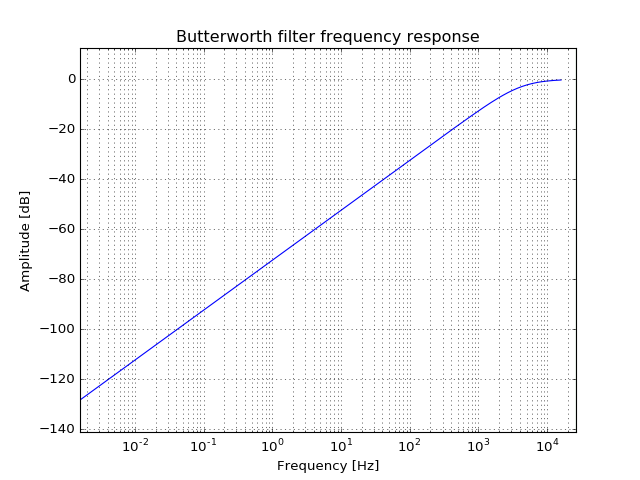

In [4]:
w, h = signal.freqs(b, a)
plt.figure(1)
plt.semilogx(w/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(freq_HPF, color='green') # cutoff frequency
plt.show()

# Equivalent Digital Filter Response

<IPython.core.display.Javascript object>


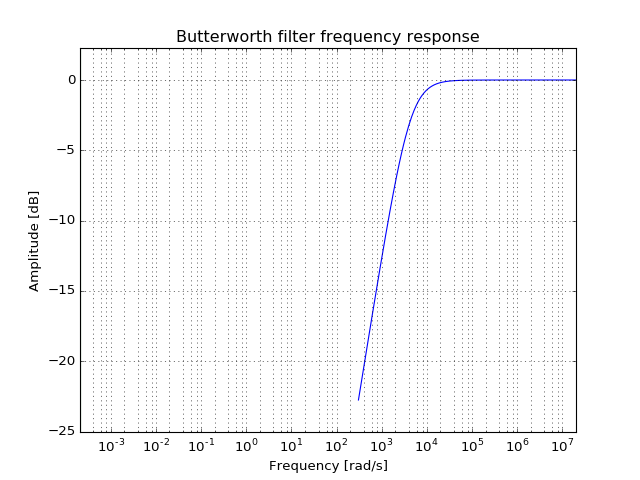

/Users/jjgomezcadenas/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


In [7]:
b, a = signal.butter(1, freq_HPFd, 'high', analog=False)
# Filter Response
w, h = signal.freqz(b, a, worN=2**16)                # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
plt.figure(2)
plt.semilogx(w*(f_sample)/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(freq_HPFd, color='green') # cutoff frequency
plt.show()

# Filtering Operation

In [8]:
signal_in = np.concatenate((np.zeros((1,1000)),np.ones((1,10000)),np.zeros((1,20000))),axis=1)
signal_out = signal.lfilter(b,a,signal_in[0,0:])

<IPython.core.display.Javascript object>


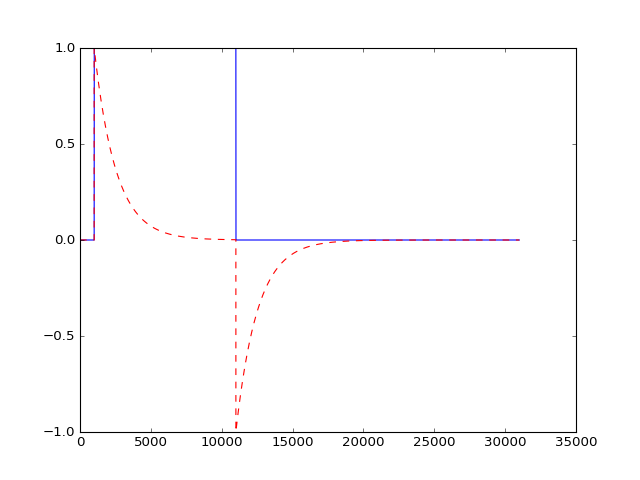

31000


In [9]:
plt.figure(3)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
print np.size(signal_out)
plt.plot(range(0,np.size(signal_in),1),signal_out,'r--', linewidth=1)
plt.show()

# Accurate Model of FEE. Complex Filter Composition 

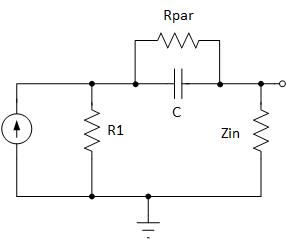

In [8]:
Image(filename = "scheme.png")

In [75]:
def gain(R1=4700*ohm,Zin=62*ohm, rpar = 1e+7*ohm):
    """
    computes the gain of the filter
    """
    r_i=R1+Zin
    R=r_i*rpar/(r_i+rpar)
    GAIN=R1*Zin/(R1+Zin+rpar) 
    return GAIN
    

In [76]:
print('gain of system = {} ohm'.format(gain()/ohm))

gain of system = 0.0291261301368 ohm


In [10]:
rpar=10E6; 
C=8E-9; 
R1=4700; 
Zin=62; 
r_i=R1+Zin; 
R=r_i*rpar/(r_i+rpar); 
GAIN=R1*Zin/(R1+Zin+rpar) 

freq_HPF=1/(R*C);
freq_LPF1=3E6*2*np.pi;
freq_LPF2=10E6*2*np.pi;
zero_rpar=1/(rpar*C)

In [11]:
freq_HPFd=freq_HPF / (f_sample*np.pi) ; print 'HPF(rad/sec) =',freq_HPF,'// (half-cycles/sample) =',freq_HPFd
freq_LPF1d=freq_LPF1 / (f_sample*np.pi) ; print 'LPF1(rad/sec) =',freq_LPF1,'// (half-cycles/sample) =',freq_LPF1d 
freq_LPF2d=freq_LPF2 / (f_sample*np.pi) ; print 'LPF2(rad/sec) =',freq_LPF2,'// (half-cycles/sample) =',freq_LPF2d
freq_zerod= zero_rpar / (f_sample*np.pi) ; print 'Zero_Rpar(rad/sec) =',zero_rpar,'// (half-cycles/sample) =',freq_zerod

HPF(rad/sec) = 26261.9750105 // (half-cycles/sample) = 0.000208986156914
LPF1(rad/sec) = 18849555.9215 // (half-cycles/sample) = 0.15
LPF2(rad/sec) = 62831853.0718 // (half-cycles/sample) = 0.5
Zero_Rpar(rad/sec) = 12.5 // (half-cycles/sample) = 9.94718394324e-08


In [12]:
b0, a0 = signal.butter(1, freq_HPFd, 'high', analog=False)

In [13]:
b1, a1 = signal.butter(1, freq_LPF1d, 'low', analog=False); b2, a2 = signal.butter(4, freq_LPF2d, 'low', analog=False);

In [14]:
b_aux=np.convolve(b0,b1,mode='full') 
b_aux2=np.convolve(b_aux,b2,mode='full'); b=GAIN*np.convolve(b_aux2,np.array((1,freq_zerod)))

In [15]:
a_aux=np.convolve(a0,a1,mode='full'); a=np.convolve(a_aux,a2,mode='full')

In [16]:
signal_out = signal.lfilter(b,a,signal_in[0,0:])

# Filter is defined by Polynomials b & a. Use lfilter for filter computation

<IPython.core.display.Javascript object>


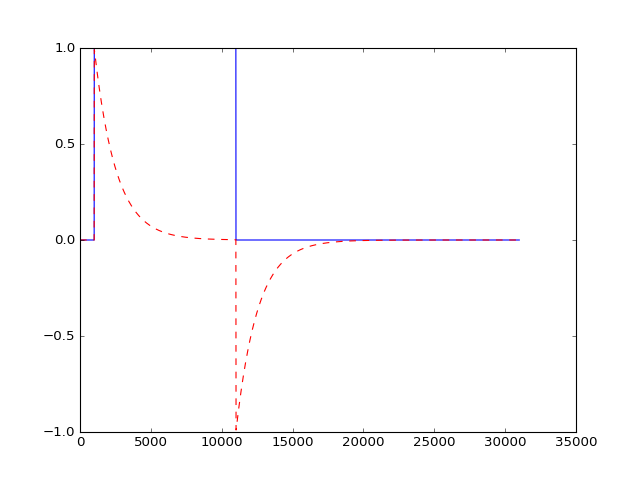

31000


In [17]:
plt.figure(4)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
print np.size(signal_out)
plt.plot(range(0,np.size(signal_in),1),(1/GAIN)*signal_out,'r--', linewidth=1)
plt.show()

In [77]:
def fee_lpf(freq_LPF1=3E6*2*np.pi,freq_LPF2=10E6*2*np.pi,rpar=10E6*ohm, C= 6*nF):
    """
    low pass filter part of the filter, accurate model
    """
    b0, a0 = signal.butter(1, freq_LPF1d, 'low', analog=False) 
    b1, a1 = signal.butter(4, freq_LPF2d, 'low', analog=False)
    b_aux=np.convolve(b0,b1,mode='full')
    zero_rpar=1/(rpar*C)
    b=(gain()/ohm)*np.convolve(b_aux,np.array((1,freq_zerod)))
    a=np.convolve(a0,a1,mode='full')
    return b,a

In [78]:
def fee_lpf0(freq_LPF1=3E6*2*np.pi):
    """
    lpf, simple model
    """
    b, a = signal.butter(1, freq_LPF1d, 'low', analog=False) 
    return b*(gain()/ohm),a

In [21]:
signal_out = signal.lfilter(b,a,signal_in[0,0:])

<IPython.core.display.Javascript object>


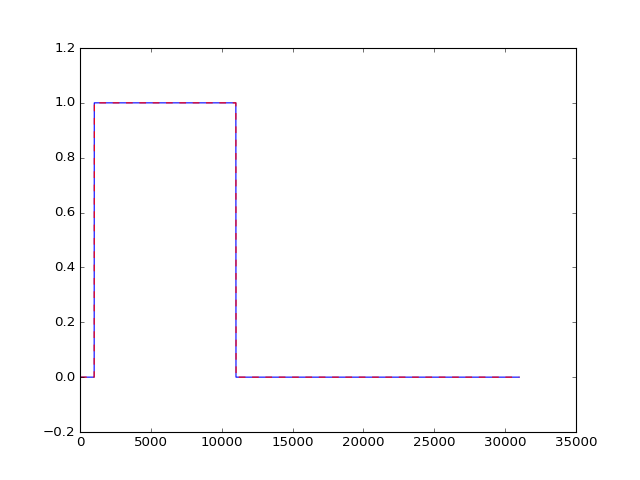

31000


In [22]:
plt.figure(5)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
print np.size(signal_out)
plt.plot(range(0,np.size(signal_in),1),(1/GAIN)*signal_out,'r--', linewidth=1)
plt.show()

In [23]:
from Util import *

In [24]:
import FEParam as FP

In [43]:
def single_pe(pmt_gain=4.5e6,x_slope = 5*ns, x_flat = 1*ns):
    """
    define a single photoelectron
    """
    spe_base = x_slope + x_flat
    spe_length = 2*x_slope + x_flat

    A=pmt_gain*eplus/spe_base  #current  
    V = A*FP.spe_i_to_v()
    nns = int(x_slope/FP.time_step)
    nnf = int(x_flat/FP.time_step)
    rise = np.linspace(0,A, num=nns)
    fall = np.linspace(A,0, num=nns)
    flat = A*np.ones(nnf)
    spe=np.concatenate((rise,flat,fall))
    return spe

<IPython.core.display.Javascript object>


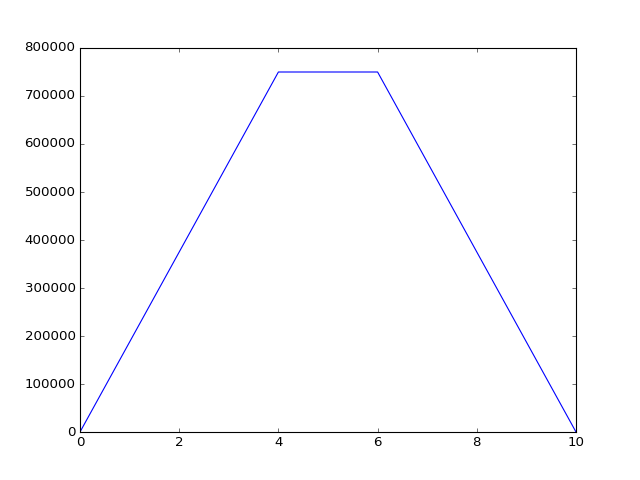

In [44]:
plt.plot(single_pe())

In [34]:
from scipy import signal as SGN

In [32]:
def spe_pulse(spe,t0, tmax=1e+6*ns):
    """
    Returns a SPE pulse at time t0
    with baseline extending in steps of time_step from 0 to tmax determined by DELTA_L
    """
    n = int(t0/FP.time_step)
    nmax = int(tmax/FP.time_step)
   
    DELTA=np.zeros(nmax)   #Dirac delta of size DELTA_L
    DELTA[n]=1
    step = FP.time_step/ns
    spe_pulse = SGN.convolve(DELTA, spe)
    
    return spe_pulse

In [52]:
spep = spe_pulse(single_pe(),100, tmax=200*ns)

<IPython.core.display.Javascript object>


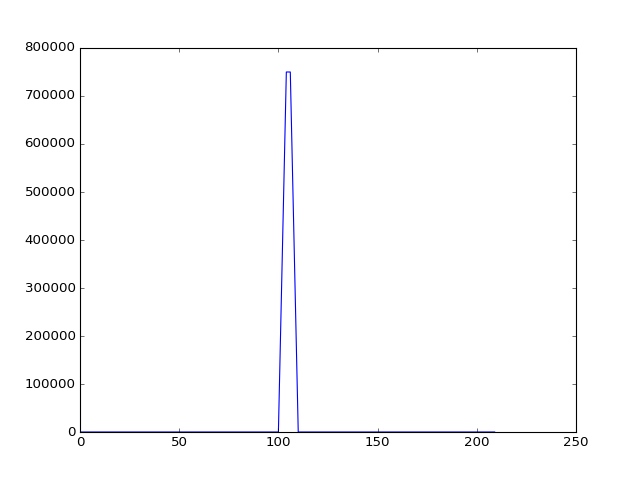

In [46]:
plt.plot(spep)

In [79]:
b,a = fee_lpf()

In [80]:
signal_out = signal.lfilter(b,a,spep)

<IPython.core.display.Javascript object>


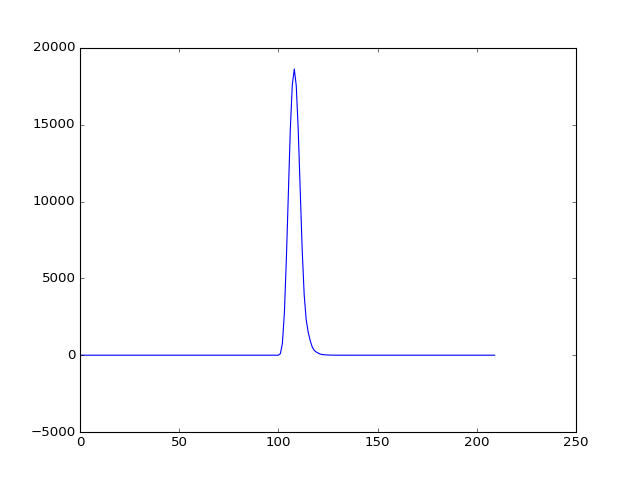

In [81]:
plt.plot(signal_out)

In [82]:
b,a = fee_lpf0()

In [83]:
signal_out = signal.lfilter(b,a,spep)

<IPython.core.display.Javascript object>


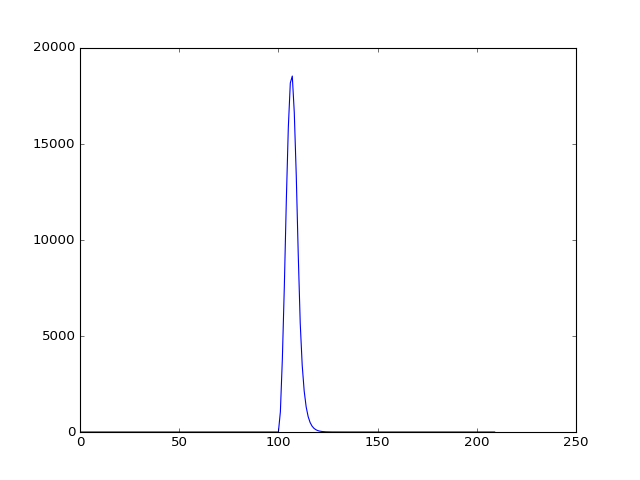

In [84]:
plt.plot(signal_out)

#### Notice that simple and accurate lpf models gives very similar results 

# Recontruction Using BLRc (BLR for Calibration)

<IPython.core.display.Javascript object>


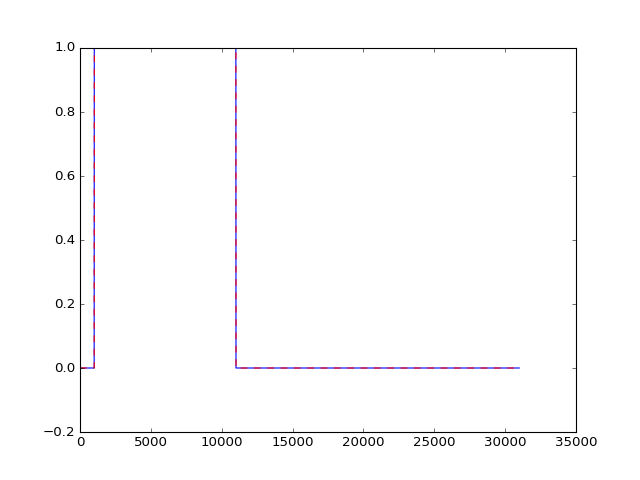

Input Energy = 10000.0
Reconstructed Energy = 9997.1352307
Error in Energy Computation (%) =  0.0286476929661


In [17]:
recons=BLRc(signal_daq=signal_out,coef=freq_HPFd*np.pi,thr1 = 0.01)*(1/GAIN)

plt.figure(5)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
plt.plot(range(0,np.size(recons),1),recons,'r--', linewidth=1)
plt.show()
# plt.figure(6)
# plt.plot(range(0,np.size(recons),1),recons-signal_in[0,0:],'g--', linewidth=0.5)
# plt.show()
print 'Input Energy =', np.sum(signal_in)
print 'Reconstructed Energy =', np.sum(recons)
print 'Error in Energy Computation (%) = ', (np.sum(signal_in)-np.sum(recons))/np.sum(signal_in)*100

In [18]:
print 'Coefficient used in BLRc =', freq_HPFd*np.pi
print 'Mean coefficient obtained through calibration =', '1.623E-3'
print 'Capacitor Loss=', 1.623E-3/(freq_HPFd*np.pi), ' Real Capacitor Value= ', (C/(1.623E-3/(freq_HPFd*np.pi)))

Coefficient used in BLRc = 0.000656549375262
Mean coefficient obtained through calibration = 1.623E-3
Capacitor Loss= 2.47201514639  Real Capacitor Value=  3.23622612575e-09


# The Capacitance Loss measured during the calibration is real since it has been confirmed using the tau of the pulse tail (only depends on the AC-RC). Capacitor Datasheet (CG0 type) predicts almost no deviation in the whole DC range but maybe the MLCCs show a stronger dependency when Voltage is very high (to be confirmed)